In [4]:
"""
Calculate the percent forest cover, percent aspen cover from LANDFIRE

maxwell.cook@colorado.edu
"""

import os, time
import numpy as np

import pandas as pd
import geopandas as gpd
import rioxarray as rxr
import rasterio as rio
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from rasterstats import zonal_stats

proj = 'EPSG:5070'

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'

print("Complete")

Complete


In [5]:
# Load the study region data

# Southern Rockies
sr = os.path.join(maindir,'aspen-fire/Aim1/data/spatial/raw/boundaries/us_eco_l3_srme.gpkg')
# White River NF
wr = os.path.join(maindir,'aspen-fire/Aim1/data/spatial/raw/boundaries/wrnf_boundary.gpkg')

# Load the LANDFIRE data

# Existing Vegetation Type (EVT)
evt_path = os.path.join(maindir,'data/landcover/LANDFIRE/LF2016_EVT_200_CONUS/Tif/LC16_EVT_200.tif')
# Tree Canopy Cover (TCC)
tcc_path = os.path.join(maindir,'data/landcover/LANDFIRE/LF2020_CC_200_CONUS/Tif/LC20_CC_200.tif')



## Calculate the percent aspen forest cover for the Southern Rockies and White River NF

Based on the LANDFIRE EVT (ca. 2016 remap), calculate the percent cover of aspen forest classes in both study regions.

In [12]:
# Read in the lookup table for the EVT codes
lookup = os.path.join(maindir,'data/landcover/LANDFIRE/LF2016_EVT_200_CONUS/CSV_Data/LF16_EVT_200.csv')
lookup = pd.read_csv(lookup)
lookup = lookup[['VALUE','EVT_NAME','EVT_PHYS','EVT_GP_N','EVT_CLASS']]
print(lookup.columns)

Index(['VALUE', 'EVT_NAME', 'EVT_PHYS', 'EVT_GP_N', 'EVT_CLASS'], dtype='object')


In [28]:
begin = time.time()

regions = [sr, wr]
attrs = ['NA_L3NAME','FORESTNAME']

evt_results = []

for i in range(len(regions)):
    # Gather the data and attributes
    roi = regions[i]
    attr = str(attrs[i])
    
    print(f'Processing for {os.path.basename(roi)}')

    # Read the spatial file
    roi = gpd.read_file(roi)
    roi = roi.to_crs(proj) # ensure the correct projection
    
    # Zonal statistics
    zs = zonal_stats(vectors=roi[[attr,'geometry']], raster=evt_path, categorical=True, geojson_out=True)
    stats = gpd.GeoDataFrame(zs).fillna(0) # One column per raster category, and pixel count as value

    # Extract the information
    # First get the unique ID 
    stats[attr] = stats['properties'].apply(lambda x: x.get(attr))
    
    # Retrieve the EVT codes and percent cover
    stats['properties'] = stats['properties'].apply(lambda x: {key: val for key, val in x.items() if key != attr})
    stats['properties_list'] = stats['properties'].apply(lambda x: list(x.items()))
    props = stats.explode('properties_list').reset_index(drop=True) # Explode the json
    # retrieve the list items as new columns
    props[['EVT', 'pixel_count']] = pd.DataFrame(props['properties_list'].tolist(), index=props.index)
    props = props[[attr,'EVT','pixel_count']].reset_index(drop=True)
    # Calculate the percent of each class
    total_pixels = props.groupby(props[attr])['pixel_count'].transform('sum')
    props['total_pixels'] = total_pixels
    props['pct_cover'] = (props['pixel_count'] / props['total_pixels']) * 100
    # Tidy the columns
    props = props[[attr,'EVT','pixel_count','total_pixels','pct_cover']]

    # Merge to the EVT attributes from the lookup table
    props = props.merge(lookup, left_on='EVT', right_on='VALUE', how='left')
    props = props.drop(['VALUE'], axis=1)

    #####################################
    # Calculate the percent forested area
    evt_cover = (
        props[[attr, 'EVT_CLASS', 'pixel_count']]
        .pivot_table(index=attr, columns='EVT_CLASS', values='pixel_count', aggfunc='sum', fill_value=0)
    )

    # Forest classes
    forests = ['Open tree canopy', 'Closed tree canopy', 'Sparse tree canopy']
    evt_cover['forest_pixels'] = evt_cover[forests].sum(axis=1) # Calculate the percent forest
    # Merge back
    props = props.merge(evt_cover[['forest_pixels']], on=attr)
    props['pct_forest'] = (props['forest_pixels'] / props['total_pixels']) * 100

    #######################################
    # Calculate the percent conifer forests
    evt_cover = (
        props[[attr, 'EVT_PHYS', 'pixel_count']]
        .pivot_table(index=attr, columns='EVT_PHYS', values='pixel_count', aggfunc='sum', fill_value=0)
    )

    # Conifer classes
    forests = ['Conifer']
    evt_cover['forest_pixels'] = evt_cover[forests].sum(axis=1) # Calculate the percent forest
    # Merge back
    props = props.merge(evt_cover[['forest_pixels']], on=attr)
    props['pct_forest'] = (props['forest_pixels'] / props['total_pixels']) * 100

    ###################################
    # Calculate the percent aspen cover
    evt_cover = (
        props[[attr, 'EVT_NAME', 'pixel_count']]
        .pivot_table(index=attr, columns='EVT_NAME', values='pixel_count', aggfunc='sum', fill_value=0)
    )
    
    # Aspen classes
    aspen = ['Rocky Mountain Aspen Forest and Woodland', 'Inter-Mountain Basins Aspen-Mixed Conifer Forest and Woodland']
    evt_cover['aspen_pixels'] = evt_cover[aspen].sum(axis=1) # Calculate the percent forest
    # Merge back
    props = props.merge(evt_cover[['aspen_pixels']], on=attr)
    props['pct_aspen_forest'] = (props['aspen_pixels'] / props['forest_pixels']) * 100

    # Calculate the forest and aspen area in km2
    props['forest_area'] = ((props['forest_pixels'] * 900) / 1000000)
    props['aspen_area'] = ((props['aspen_pixels'] * 900) / 1000000)
    
    # Append to a list
    evt_results.append(props)

    del roi, zs, stats, props, evt_cover, forests, aspen

    print(f"Time to complete ROI: {round((time.time() - begin))} seconds.")

# Check the results
print(evt_results[0].head())
print(evt_results[1].head())

print(f"Total elapsed time: {round((time.time() - begin))} seconds.")

Processing for us_eco_l3_srme.gpkg
Time to complete ROI: 14 seconds.
Processing for wrnf_boundary.gpkg
Time to complete ROI: 15 seconds.
          NA_L3NAME   EVT  pixel_count  total_pixels  pct_cover  \
0  Southern Rockies  7011     14409780     161890734   8.900929   
1  Southern Rockies  7016      3225709     161890734   1.992522   
2  Southern Rockies  7049        43557     161890734   0.026905   
3  Southern Rockies  7050      9205354     161890734   5.686152   
4  Southern Rockies  7051      8768923     161890734   5.416569   

                                            EVT_NAME  EVT_PHYS  \
0           Rocky Mountain Aspen Forest and Woodland  Hardwood   
1           Colorado Plateau Pinyon-Juniper Woodland   Conifer   
2  Rocky Mountain Foothill Limber Pine-Juniper Wo...   Conifer   
3               Rocky Mountain Lodgepole Pine Forest   Conifer   
4  Southern Rocky Mountain Dry-Mesic Montane Mixe...   Conifer   

                                            EVT_GP_N           

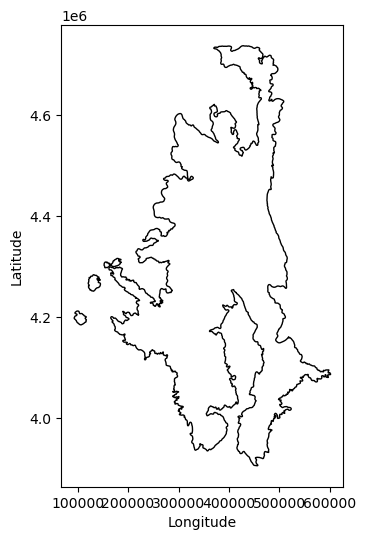

In [37]:
# Study area map

proj = 'EPSG:26913'

sr = os.path.join(maindir,'aspen-fire/Aim1/data/spatial/raw/boundaries/us_eco_l3_srme.gpkg')
sr = gpd.read_file(sr)
sr = sr.to_crs(proj)

# Load the state boundaries
states = gpd.read_file(os.path.join(maindir,'data/boundaries/political/TIGER/tl19_us_states_west_nad83.gpkg'))

# Map
fig, ax = plt.subplots(figsize=(6, 6))

sr.plot(ax=ax, edgecolor='black', linewidth=1, color='none')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(False)

# # Save the map as a PNG
# plt.savefig(os.path.join(maindir,'aspen-fire/Aim2/figures/Fig1_aspen_fires.png'), dpi=300, bbox_inches='tight')

plt.show()